In [3]:
import json
import matplotlib 
from matplotlib import pyplot as plt
import os 

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)


figure_path = "/Users/Elias/vagueness/figures"
def parse_results(json_path):
    with open(json_path) as f1:
        data = json.load(f1)
    to_ret = {}
    for line in data:
        try:
            to_ret[line["question_id"]] = line
        except KeyError:
            to_ret[line["questionId"]] = line
    return to_ret

def parse_inputs(json_path):
    to_ret = {}
    with open(json_path) as f1:
        data = json.load(f1) 
    for instance in data:
        try:
            instance_dict = {"qid": instance["question_id"],
                             "sent": instance["sent"],
                             "answers": instance["score_answers"],
                             "mean_ans": sum(instance["score_answers"])/len(instance["score_answers"]), 
                             "img_id": instance["img_id"]
                            }
        except KeyError:
            # gqa
            instance_dict = {"qid": instance["question_id"],
                         "sent": instance["question"],
                         "answers": [1] if instance["answer"] == "yes" else [0],
                         "mean_ans": 1 if instance["answer"] == "yes" else 0, 
                         "img_id": instance["image_id"]
                        }
        to_ret[instance["question_id"]] = instance_dict
    return to_ret
    
        

In [4]:


def simple_plot(inputs_path, results_path):
    """
    simple plot for comparing the results 
    """
    split = os.path.basename(inputs_path).split(".")[0]
    inputs = parse_inputs(inputs_path)
    results = parse_results(results_path)
    
    to_plot_human_scores = []
    to_plot_colors = []
    to_plot_yes = []
    to_plot_no = []
    to_plot_xs = []
    
    # sort inputs by mean answer
    sorted_inputs = sorted(inputs.items(), key = lambda x: x[1]["mean_ans"])
    keys = [x[0] for x in sorted_inputs]
    
    for i, qid in enumerate(keys):
        input_data = inputs[qid]
        result_data = results[qid]
        
        
#         try:
        to_plot_human_scores.append(input_data["mean_ans"])
        to_plot_yes.append(result_data["answer"]["yes"])
        to_plot_no.append(result_data["answer"]["no"])
        to_plot_xs.append(i)
        if input_data["mean_ans"] > 0.5:
            color = "True"
        else:
            color = "False"
        to_plot_colors.append(color)

#         except KeyError:
#             continue
            
    
    markers = {"True": "." ,
           "False": "."}
    
    palette = {"True": '#4575b4' ,
           "False": '#d73027'}
            
    # VERSION 1
    plt.figure()
    fig, axs = plt.subplots(3, 1, sharex='col', figsize=(6,6))
    for x, y, c in zip(to_plot_xs, to_plot_human_scores, to_plot_colors):
        axs[0].scatter([x], [y], s = 150, marker = markers[c], color = palette[c])

    for x, y, c in zip(to_plot_xs, to_plot_yes, to_plot_colors):
        axs[1].scatter([x], [y], s = 150, marker = markers[c], color = palette[c])  
    
    for x, y, c in zip(to_plot_xs, to_plot_no, to_plot_colors):
        axs[2].scatter([x], [y], s = 150, marker = markers[c], color = palette[c])  
        

    axs[1].set_yticks([0.0, 1.0])
    axs[1].set_yticklabels([0.0, 1.0])
    for i in range(len(axs)):
        axs[i].set_xticks([])
        axs[i].set_xticklabels([])
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
    #     axs[i].spines['bottom'].set_visible(False)
    #     axs[i].spines['left'].set_visible(False)
    # axs[0].spines['bottom'].set_visible(True)
    plt.tight_layout()
    plt.savefig(os.path.join(figure_path, f"{split}.pdf")) 


In [ ]:
simple_plot("/Users/Elias/vagueness/data/output_new_scored.json", "/Users/Elias/vagueness/results/output_new_scored.json")

In [ ]:
simple_plot("/Users/Elias/vagueness/data/output_sunny_scored.json", "/Users/Elias/vagueness/results/output_sunny_scored.json")

In [ ]:
simple_plot("/Users/Elias/vagueness/data/output_cloudy_scored.json", "/Users/Elias/vagueness/results/output_cloudy_scored.json")

In [20]:
import pathlib 
import sys
cwd = pathlib.Path.cwd()
sys.path.insert(0, str(cwd.parent.joinpath("turk", "analysis")))
from analysis import parse_csv
from collections import defaultdict
import numpy as np

# TODO: parse turk results to get GQA vagueness
def parse_turk(path):
    data = parse_csv(path)
    data_by_qid = defaultdict(list)
    for line in data:
        data_by_qid[line["question_id"]].append(line["p_true"]/100)
    
    to_ret = {}
    for k,v in data_by_qid.items(): 
        to_ret[k] = np.mean(v)
    return to_ret

def calculate_accuracy(inputs_path, results_path, turk_path=None, mode = "total"):
    split = os.path.basename(inputs_path).split(".")[0]
    inputs = parse_inputs(inputs_path)
    results = parse_results(results_path)
    turk_results = None
    if turk_path is not None:
        turk_results = parse_turk(turk_path)
    
    correct = 0.0 
    total_examples = 0.0 
    skipped, non_skipped = 0,0
    total = 0.0 
    for qid in inputs.keys():
        if turk_results is not None and qid not in turk_results.keys():
            continue
            
        inp = inputs[qid]
        out = results[qid]
#         inp_score = sum(inp["answers"])/len(inp["answers"])
        inp_score = inp["answers"][0]
        try:
            out_score = out["answer"]["yes"]
        except KeyError:
            # gqa
            out_score = out["prediction"]["yes"]
        
        total_examples += 1
        # skip vague vqa
        if mode == "non-vague" and turk_results is None and not (inp["mean_ans"] == 0 or inp["mean_ans"] == 1):
            skipped += 1
            continue 
        # skip vague gqa
        if mode == "non-vague" and turk_results is not None and not (turk_results[qid] < 0.20 or turk_results[qid] > 0.80):
            skipped += 1
            continue 
            
        # skip non-vague vqa
        if mode == "vague" and turk_results is None and (inp["mean_ans"] == 0 or inp["mean_ans"] == 1):
            skipped += 1
            continue 
        # skip non-vague gqa
        if mode == "vague" and turk_results is not None and (turk_results[qid] < 0.20 or turk_results[qid] > 0.80):
            skipped += 1
            continue
        
        if (inp_score < 0.5 and out_score < 0.5) or (inp_score >= 0.5 and out_score >= 0.5):
             correct += 1
        total += 1     
        
    print(f"{mode} skipped {skipped} of {total}: {skipped/total * 100}")
    percentage_of_data = (total_examples - skipped)/total_examples
#     print(f"total {total}")
    return "%0.2f" % (correct/total * 100), percentage_of_data


In [21]:

def get_acc_vqa(filename):

    input_path = f"/Users/Elias/vagueness/data/vqa/json/outputs_json_yesno_checked/{filename}.json"
    output_path = f"/Users/Elias/vagueness/results/lxmert/vqa/{filename}.json"
    name = pathlib.Path(output_path).stem.split("_")[1]
#     try:
    total_acc, total_perc = calculate_accuracy(input_path, output_path)
    print(f"{filename}  total {total_acc}") 
    vague_acc, vague_perc = calculate_accuracy(input_path, output_path, mode="vague")
    print(f"{filename}  vague only {vague_acc}") 
    nonvague_acc, nonvague_perc = calculate_accuracy(input_path, output_path, mode="non-vague")
    print(f"{filename}  non-vague only {nonvague_acc}") 
    assert((vague_perc + nonvague_perc) - 1.0 < 0.001)

    return name, total_acc, vague_acc, nonvague_acc, vague_perc, nonvague_perc
#     except:
#         print(f"error with {filename}")
    
vqa_acc_results = {}
all_vague_percs = []
all_nonvague_percs = []
all_vague_accs = []
for filename in ["output_adult_wurl_yesno_checked", "output_cloudy_wurl_yesno_checked",
                "output_sunny_wurl_yesno_checked", "output_new_wurl_yesno_checked",
                "output_old_wurl_yesno_checked", "output_young_wurl_yesno_checked"]:
    name, acc, vague_acc, nonvague_acc, vague_perc, nonvague_perc = get_acc_vqa(filename)
    all_vague_percs.append(vague_perc)
    all_nonvague_percs.append(nonvague_perc)
    all_vague_accs.append(float(vague_acc))
    vqa_acc_results[name] = (acc, vague_acc, nonvague_acc)

    
print(f"mean percentage vague {np.mean(all_vague_percs) * 100}")
print(f"mean percentage nonvague {np.mean(all_nonvague_percs) * 100}")
print(f"mean vague accuracy {np.mean(all_vague_accs) }")
      

total skipped 0 of 63.0: 0.0
output_adult_wurl_yesno_checked  total 79.37
vague skipped 31 of 32.0: 96.875
output_adult_wurl_yesno_checked  vague only 59.38
non-vague skipped 32 of 31.0: 103.2258064516129
output_adult_wurl_yesno_checked  non-vague only 100.00
total skipped 0 of 299.0: 0.0
output_cloudy_wurl_yesno_checked  total 88.29
vague skipped 180 of 119.0: 151.26050420168067
output_cloudy_wurl_yesno_checked  vague only 70.59
non-vague skipped 119 of 180.0: 66.11111111111111
output_cloudy_wurl_yesno_checked  non-vague only 100.00
total skipped 0 of 566.0: 0.0
output_sunny_wurl_yesno_checked  total 88.16
vague skipped 302 of 264.0: 114.3939393939394
output_sunny_wurl_yesno_checked  vague only 75.00
non-vague skipped 264 of 302.0: 87.41721854304636
output_sunny_wurl_yesno_checked  non-vague only 99.67
total skipped 0 of 236.0: 0.0
output_new_wurl_yesno_checked  total 80.93
vague skipped 105 of 131.0: 80.1526717557252
output_new_wurl_yesno_checked  vague only 65.65
non-vague skipped 1

In [19]:

def get_acc_gqa(filename):
    input_path = f"/Users/Elias/vagueness/data/gqa/json/outputs_json_small/{filename}.json"
    output_path = f"/Users/Elias/vagueness/results/lxmert/gqa/{filename}.json"
    name = pathlib.Path(output_path).stem.split("_")[1]
    
    turk_path = f"/Users/Elias/vagueness/results/turk/gqa/clean_and_norm_{name}.csv"
#     try:

    total_acc, total_perc = calculate_accuracy(input_path, output_path, turk_path = turk_path)
    print(f"{filename}  total {total_acc}") 
    vague_acc, vague_perc = calculate_accuracy(input_path, output_path, turk_path = turk_path, mode="vague")
    print(f"{filename}  vague only {vague_acc}") 
    nonvague_acc, nonvague_perc = calculate_accuracy(input_path, output_path,turk_path = turk_path, mode="non-vague")
    print(f"{filename}  non-vague only {nonvague_acc}") 
    assert((vague_perc + nonvague_perc) - 1.0 < 0.001)

    return name, total_acc, vague_acc, nonvague_acc, vague_perc, nonvague_perc

gqa_acc_results = {} 
all_vague_percs = []
all_nonvague_percs = []
all_vague_accs = []
for filename in ["output_adult_yesno_small", "output_cloudy_yesno_small",
                "output_sunny_yesno_small", "output_new_yesno_small",
                "output_old_yesno_small", "output_young_yesno_small"]:
# for filename in ["output_cloudy_yesno_small"]:
    name, acc, vague_acc, nonvague_acc, vague_perc, nonvague_perc = get_acc_gqa(filename)
    all_vague_percs.append(vague_perc)
    all_nonvague_percs.append(nonvague_perc)
    all_vague_accs.append(float(vague_acc))
    gqa_acc_results[name] = (acc, vague_acc, nonvague_acc)

    
print(f"mean percentage vague {np.mean(all_vague_percs) * 100}")
print(f"mean percentage nonvague {np.mean(all_nonvague_percs) * 100}")
print(f"mean vague accuracy {np.mean(all_vague_accs) }")

output_adult_yesno_small  total 76.60
output_adult_yesno_small  vague only 72.73
output_adult_yesno_small  non-vague only 80.00
output_cloudy_yesno_small  total 95.41
output_cloudy_yesno_small  vague only 92.16
output_cloudy_yesno_small  non-vague only 98.28
output_sunny_yesno_small  total 85.71
output_sunny_yesno_small  vague only 83.58
output_sunny_yesno_small  non-vague only 88.89
output_new_yesno_small  total 94.68
output_new_yesno_small  vague only 93.33
output_new_yesno_small  non-vague only 95.31
output_old_yesno_small  total 92.08
output_old_yesno_small  vague only 94.87
output_old_yesno_small  non-vague only 90.32
output_young_yesno_small  total 79.63
output_young_yesno_small  vague only 75.00
output_young_yesno_small  non-vague only 86.36
mean percentage vague 47.201157382972276
mean percentage nonvague 52.79884261702773
mean vague accuracy 85.27833333333332


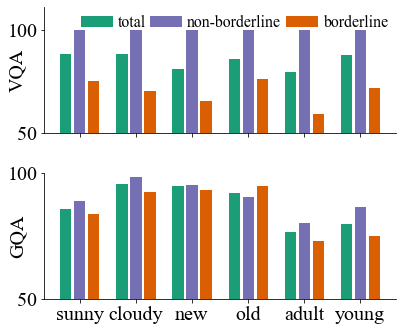

In [67]:

total_results = {"vqa": vqa_acc_results,
                "gqa": gqa_acc_results}


fig, axs = plt.subplots(2, 1, sharex = True, sharey = False, figsize=(6,5))
names = ["sunny", "cloudy", "new", "old", "adult", "young"]
total_c = "#1b9e77"
vague_c = "#d95f02"
non_vague_c = "#7570b3"

for i, key in enumerate(["vqa", "gqa"]):
    acc_data = total_results[key]
    
    xticks = []
    xticklabels = names
    for j, name in enumerate(names):
        j = j * 4
        acc, vague_acc, nonvague_acc = acc_data[name]
        acc, vague_acc, nonvague_acc = float(acc), float(vague_acc), float(nonvague_acc)
        total_handle = axs[i].bar(j , acc, color = total_c)
        non_vague_handle = axs[i].bar(j+1 , nonvague_acc, color = non_vague_c)
        vague_handle = axs[i].bar(j + 2, vague_acc, color = vague_c)
        xticks.append(j + 1)
        
    axs[i].set_ylabel(key.upper(), labelpad=-20)
    if i == 0:
        axs[i].set_ylim(50, 111)
    else:
        axs[i].set_ylim(50, 100)
        
    axs[i].set_xticks(xticks)
    axs[i].set_xticklabels(xticklabels)
    axs[i].set_yticks([50,100])
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)
    
axs[0].legend([total_handle, non_vague_handle, vague_handle], ["total", "non-borderline", "borderline"],
             ncol=3, frameon=False, borderpad=0.0, columnspacing=0.3,
             handletextpad=0.3,labelspacing=0.0, fontsize=18, prop={"size":16}) 

# plt.legend(handles = [non_vague_handle, vague_handle])
plt.tight_layout()
plt.savefig("/Users/Elias/vagueness-2020/figures/vqa_gqa_accs.pdf")

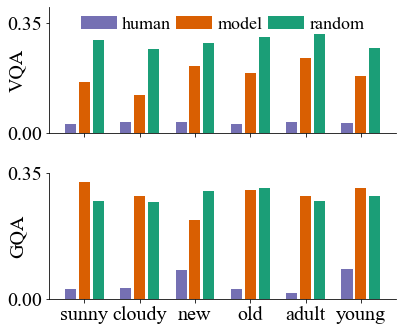

In [72]:

cwd = pathlib.Path.cwd()
data_dir = cwd.parent.parent.joinpath("results","turk")
 

total_results = {"vqa": None,
                "gqa": None}

def map_name(og_name):
    if "_" in og_name:
        split_name = og_name.split("_")[1]
        return split_name
    return og_name

for dataset in total_results.keys():
    data_path = data_dir.joinpath(dataset, "for_latex.json")
    data = json.load(open(data_path))
    new_data = {map_name(k): [float(x) for x in v] for k, v in data.items()}
    total_results[dataset] = new_data
    

fig, axs = plt.subplots(2, 1, sharex = True, sharey = False, figsize=(6,5))
names = ["sunny", "cloudy", "new", "old", "adult", "young"]


model_color = "#d95f02"
rand_color = "#1b9e77"
human_color = "#7570b3"


for i, model in enumerate(["vqa", "gqa"]):
    data = total_results[model]
    xticks = []
    xticklabels = []
    for j, name in enumerate(names):
        j = j * 4
        row = data[name]
        human_handle = axs[i].bar(j , row[0], color = human_color)
        model_handle = axs[i].bar(j + 1, row[1], color = model_color)
        random_handle = axs[i].bar(j + 2, row[2], color = rand_color)

        xticks.append(j+1)
        xticklabels.append(name)
    
    axs[i].set_ylabel(model.upper(), labelpad=-20)
    if i == 0:
        axs[i].set_ylim(0, 0.40)
    else:
        axs[i].set_ylim(0, 0.35)
        
    axs[i].set_yticks([0,0.35])
    axs[i].set_xticks(xticks)
    axs[i].set_xticklabels(xticklabels)

    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)
    #     row_data = data_for_latex[name]
    #     just_name = name.split("_")[1]
    #     human_rmse = float(row_data[0])
    #     model_rmse = float(row_data[1])
    #     random_rmse  = float(row_data[2])
    

axs[0].legend([human_handle, model_handle, random_handle], ["human", "model", "random"],
             loc = "upper center", ncol=3, frameon=False, borderpad=0.0, columnspacing=0.3,
             handletextpad=0.3,labelspacing=0.0, fontsize=20, prop={"size":18}) 

# plt.legend(handles = [non_vague_handle, vague_handle])
plt.tight_layout()
plt.savefig("/Users/Elias/vagueness-2020/figures/vqa_gqa_rmse.pdf")
    
